In [1]:
import json
import itertools
import pandas as pd
import nltk
import re
import numpy as np
from gensim.models import Word2Vec
from operator import itemgetter
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from PIL import Image
from sklearn.decomposition import PCA
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

In [4]:
## GLOBALS 
%matplotlib notebook  
# CONFIG
TRAINING_DATA_DIR="./datasets/BioASQ-trainingDataset6b.json"
# TFIDF CONFIG
TOP_N=5
MIN_DF=0.01
MAX_DF=1.00
N_GRAMS=[(1,1),(2,2),(3,3),(1,3)]
BUILD_WORD_CLOUD=False
DATA_DF=json_to_df(TRAINING_DATA_DIR)

In [5]:
# DATA ANALYSIS
[questions, q_types] = parse_questions_types(DATA_DF)
str_labels = list(np.unique(q_types))
print("Labels")
print(str_labels)
print()
y = [label_to_class(q_type) for q_type in q_types]

for label in str_labels:
    label_questions = [questions[idx] for idx, q_type in enumerate(q_types) if q_type == label]
    count = len(label_questions)   
    average_question_length = np.average([len(q) for q in label_questions])
    tfidf_weights = []

    for ngram in N_GRAMS:
        weights = build_tfidf_weights(label_questions, MIN_DF, MAX_DF, ngram, TOP_N) 
        tfidf_weights.append(weights)
    
        if BUILD_WORD_CLOUD:
            build_word_cloud(weights, f"{label}_{ngram}_world_cloud.png")

    # Logging
    print(f"Label Analysis: {label}")        
    print(f"Count: {count}")
    print(f"Average question length: {average_question_length}")
    for idx, ngram in enumerate(N_GRAMS):
        print(f"TFIDF NGRAM={ngram}: {tfidf_weights[idx]}")
    print()

Labels
['factoid', 'list', 'summary', 'yesno']

Label Analysis: factoid
Count: 619
Average question length: 62.19386106623586
TFIDF NGRAM=(1, 1): {'which': 0.17666687585992275, 'what': 0.16804829722323097, 'protein': 0.05726073370604774, 'with': 0.049438105331838546, 'syndrome': 0.04942448472129576}
TFIDF NGRAM=(2, 2): {'associated with': 0.04254730612446574, 'which gene': 0.04132425619574248, 'which protein': 0.035108389110929124, 'which disease': 0.03051130393655959, 'which enzyme': 0.02347120926424941}
TFIDF NGRAM=(3, 3): {'what mode inheritance': 0.01615508885298869, 'which most common': 0.011308562197092083, 'which enzyme inhibited': 0.011308562197092083, 'which disease treated': 0.007996361015033654, 'disease treated with': 0.007996361015033654}
TFIDF NGRAM=(1, 3): {'which': 0.16344724302352973, 'what': 0.15964600058487446, 'protein': 0.052277843570378124, 'syndrome': 0.04561186731794573, 'with': 0.04239845176921369}

Label Analysis: list
Count: 485
Average question length: 66.31

/Users/jalexander/Projects/python36/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/Users/jalexander/Projects/python36/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


<IPython.core.display.Javascript object>


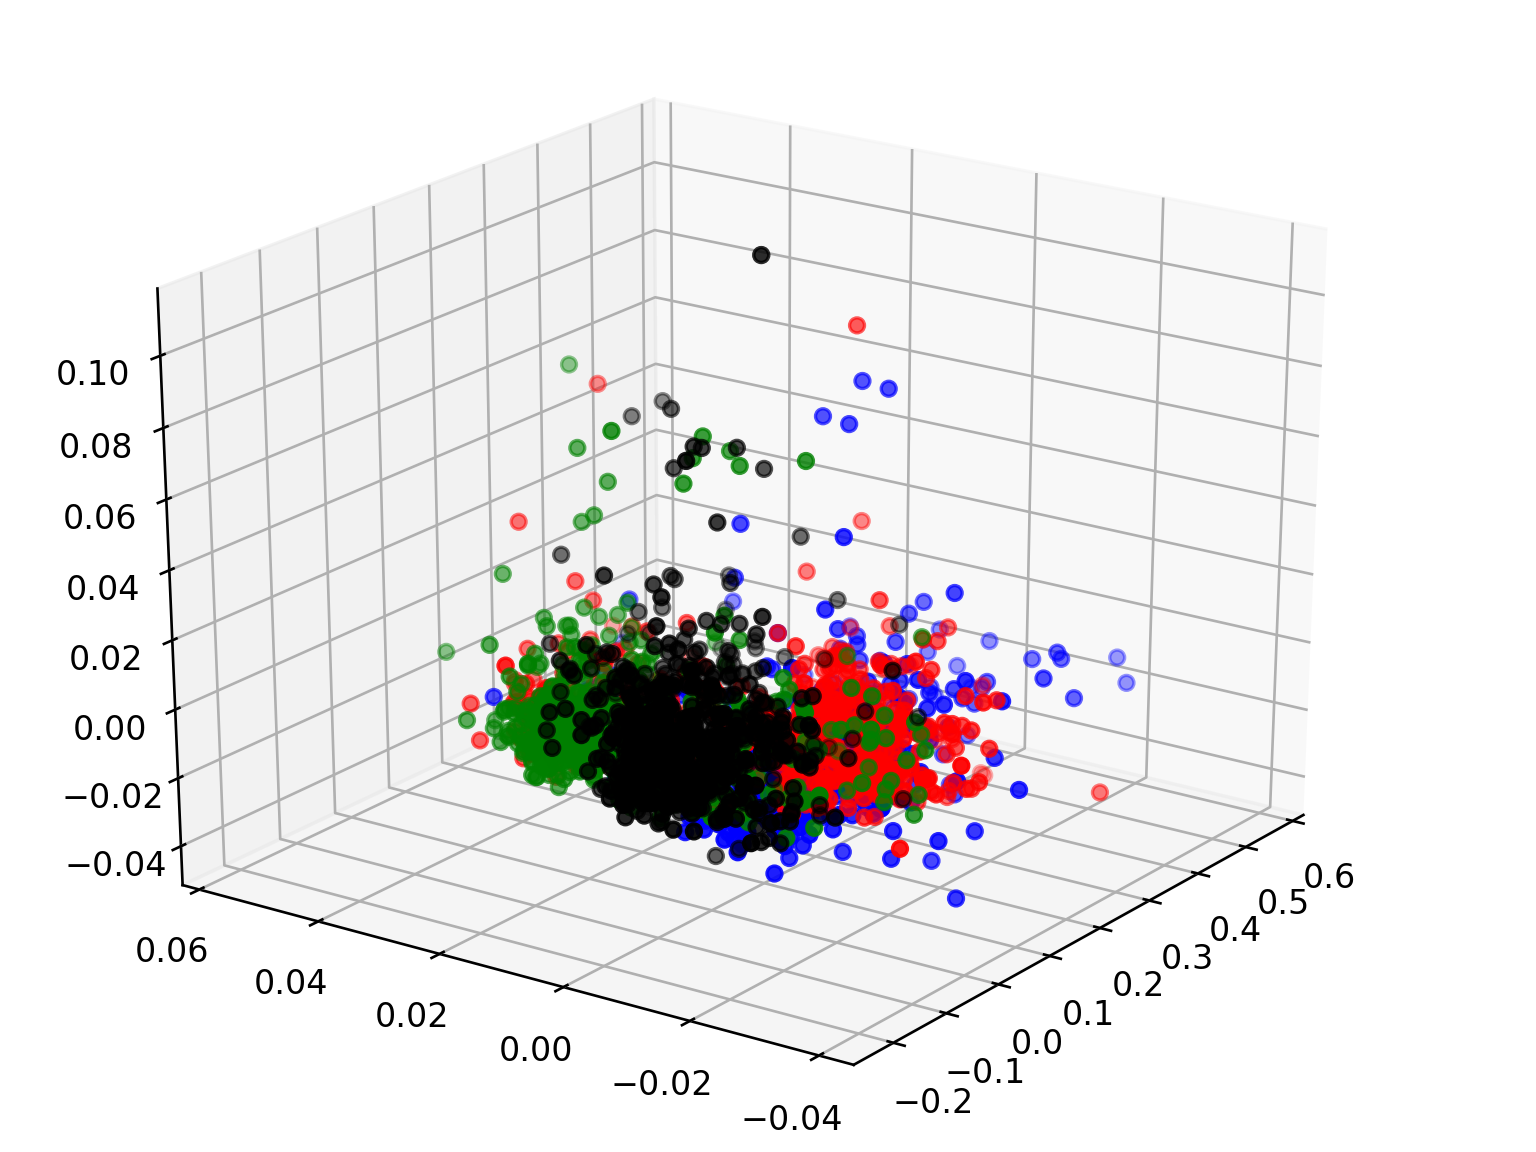

In [13]:
# MODEL BUILDING
[questions, q_types] = parse_questions_types(DATA_DF)
questions = [tokenize(q) for q in questions]
model = Word2Vec(questions, min_count=0)
str_labels = list(np.unique(q_types))
sent_vectors = []
for label in str_labels:
    label_questions = [questions[idx] for idx, q_type in enumerate(q_types) if q_type == label]
    for question in label_questions:        
        sent_vector = []
        for word in question:

            if (len(sent_vector) == 0):
                sent_vector = model[word]
            else:
                sent_vector = np.add(sent_vector, model[word])
        sent_vectors.append(sent_vector)
        
# PCA
pca = PCA(n_components=3)
pca.fit(sent_vectors)
result = pca.transform(sent_vectors)

# Plotting result
pyplot.clf()
pyplot.cla()
fig = pyplot.figure(1, figsize=(5, 5))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
colors = {
    'factoid': 'r', 
    'list': 'b', 
    'summary': 'g', 
    'yesno': 'black'
}

min_idx = 0
for label in str_labels:
    max_idx = min_idx + q_types.count(label)
    ax.scatter(result[min_idx:max_idx, 0], result[min_idx:max_idx, 1], result[min_idx:max_idx, 2], color=colors[label])
    min_idx = max_idx

In [3]:
def parse_questions_types(data):
    return zip(*[[json['body'], json['type']] for json in data['questions']])

def class_to_label(_class): 
    return str_labels[_class]

def label_to_class(label):
    return str_labels.index(label)

def build_tfidf_weights(sent_list, min_df, max_df, ngram, top_n=25):
    tfidf_vectorizer = TfidfVectorizer(
        max_df=max_df, 
        min_df=min_df, 
        tokenizer=tokenize, 
        ngram_range=ngram
    )
    tfidf = tfidf_vectorizer.fit_transform(sent_list)
    terms = tfidf_vectorizer.get_feature_names()
    return top_mean_feats(tfidf, terms, top_n=top_n)

def build_word_cloud(tfidf_weights, output_file):
    # Initialize the word cloud
    wc = WordCloud(
        background_color="white",
        max_words=1000,
        width = 1024,
        height = 720,
    )
    wc.generate_from_frequencies(tfidf_weights)
    wc.to_file(output_file)

def json_to_df(json_file_path):
    with open(json_file_path, 'r') as f:
        return pd.DataFrame(json.load(f))
    
def build_features(X):
    return {
        len(X)
    }

def top_mean_feats(Xtr, features, grp_ids=None, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_tfidf_feats(row, features, top_n):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    feats = {}
    topn_ids = np.argsort(row)[::-1][:top_n]
    for i in topn_ids:
        feats[features[i]] = row[i]

    return feats

def tokenize(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token)  and len(token) > 3:
            filtered_tokens.append(token)
        
    return filtered_tokens

build_features('Is Hirschsprung disease a mendelian or a multifactorial disorder?')

{65}